In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

encoded, lamb=64:
         t  count      mean       std
0     0.01     10  0.027203  0.001467
1     0.02     10  0.018389  0.001231
2     0.03     10  0.022492  0.001503
3     0.04     10  0.025975  0.001348
4     0.05     10  0.003461  0.000327
..     ...    ...       ...       ...
995   9.96     10  0.102788  0.027778
996   9.97     10  0.102834  0.026741
997   9.98     10  0.104077  0.028105
998   9.99     10  0.102514  0.027041
999  10.00     10  0.103289  0.027521

[1000 rows x 4 columns]


encoded, lamb=128:
         t  count      mean       std
0     0.01     10  0.009508  0.000651
1     0.02     10  0.013428  0.000721
2     0.03     10  0.013644  0.000742
3     0.04     10  0.012304  0.000782
4     0.05     10  0.004255  0.000349
..     ...    ...       ...       ...
995   9.96     10  0.033718  0.009099
996   9.97     10  0.033206  0.008650
997   9.98     10  0.033278  0.008319
998   9.99     10  0.032960  0.008369
999  10.00     10  0.033031  0.008772

[1000 rows x 4 columns]

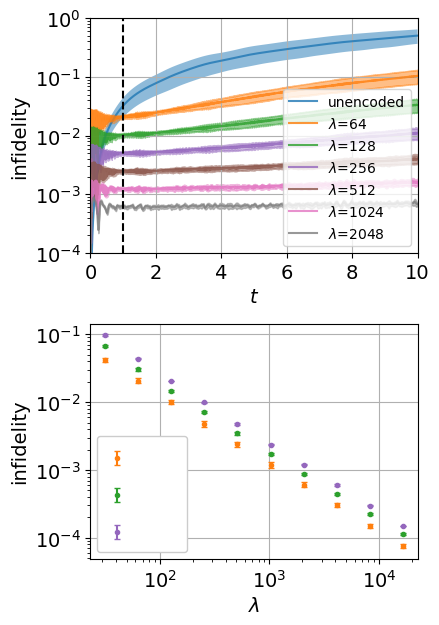

In [2]:
def get_data_from_file(filename):
    data_lamb, data_seed, data_infidelity = [], [], []

    f = open(filename)
    for line in f.readlines():
        line = line.strip().replace("#blocks =", "").replace("noise =", "").replace("lamb =", "").replace(
            "t =", "").replace("seed =", "").replace("innerprod =", "").replace("leakage =", "").replace(
            "postsel_", "").replace(",", "")
        _, _, lamb, _, seed, innerprod, _, _ = line.split()
        data_lamb.append(int(lamb))
        data_seed.append(int(seed))
        data_infidelity.append(1 - abs(complex(innerprod)) ** 2)
    f.close()

    df = pd.DataFrame(data={
        "lamb": data_lamb,
        "seed": data_seed,
        "infidelity": data_infidelity
    })

    assert np.all(df["lamb"].unique() == 2 ** np.arange(5, 15))

    newdf = df.groupby("lamb")["infidelity"].agg(['count', 'mean', 'std']).reset_index()
    lamb_arr = newdf["lamb"].to_numpy()
    mean_arr = newdf["mean"].to_numpy()
    std_arr = newdf["std"].to_numpy()
    return lamb_arr, mean_arr, std_arr

fig, axs = plt.subplots(2,1,figsize=(4,6))
fig.tight_layout(w_pad=1)
plt.subplots_adjust(hspace=0.3)


############################ 2d TFI, sweep time ############################
ax = axs[0]
##### unencoded #####
data_t, data_seed, data_infidelity = [], [], []

f = open("2dTFIM_sweep_time_unencoded_3x2_noise=0.1.txt")
for line in f.readlines():
    line = line.strip().replace("#rows =", "").replace("#columns =", "").replace("noise =", "").replace(
        "t =", "").replace("seed =", "").replace("innerprod =", "").replace(",", "")
    _, _, _, t, seed, innerprod = line.split()
    data_t.append(float(t))
    data_seed.append(int(seed))
    data_infidelity.append(1 - abs(complex(innerprod)) ** 2)
f.close()

df = pd.DataFrame(data={
    "t": data_t,
    "seed": data_seed,
    "infidelity": data_infidelity
})

newdf = df.groupby("t")["infidelity"].agg(['count', 'mean', 'std']).reset_index()
t_arr = newdf["t"].to_numpy()
mean_arr = newdf["mean"].to_numpy()
std_arr = newdf["std"].to_numpy()

ax.plot(t_arr, mean_arr, label='unencoded', alpha = 0.8)
ax.fill_between(t_arr, mean_arr + std_arr, mean_arr - std_arr, alpha = 0.5)

##### encoded #####
for lamb, color in zip([64, 128, 256, 512, 1024, 2048], ["C1", "C2", "C4", "C5", "C6", "C7"]):
    data_t, data_seed, data_infidelity = [], [], []

    f = open(f"2dTFIM_sweep_time_3x2_noise=0.1_lamb={lamb}.txt")
    cnt = 0
    for line in f.readlines():
        line = line.strip().replace("#blocks =", "").replace("noise =", "").replace("lamb =", "").replace(
            "t =", "").replace("seed =", "").replace("innerprod =", "").replace("leakage =", "").replace(
            "postsel_", "").replace(",", "")
        _, _, _, t, seed, innerprod, _, _ = line.split()
        if cnt % 1 == 0:
            data_t.append(float(t))
            data_seed.append(int(seed))
            data_infidelity.append(1 - abs(complex(innerprod)) ** 2)
        cnt += 1
    f.close()

    df = pd.DataFrame(data={
        "t": data_t,
        "seed": data_seed,
        "infidelity": data_infidelity
    })

    newdf = df.groupby("t")["infidelity"].agg(['count', 'mean', 'std']).reset_index()
    print(f"encoded, lamb={lamb}:")
    print(newdf)
    print("\n")
    t_arr = newdf["t"].to_numpy()
    mean_arr = newdf["mean"].to_numpy()
    std_arr = newdf["std"].to_numpy()

    ax.plot(t_arr, mean_arr, label=r"$\lambda$=" + f"{lamb}", alpha = 0.8, color=color)
    ax.fill_between(t_arr, mean_arr + std_arr, mean_arr - std_arr, alpha = 0.5, color=color)

ax.plot([1,1], [0.0001,1.0], color="black", linestyle="--")

ax.set_ylim(0.0001,1.0)
ax.set_xlim(0, 10)
ax.set_xlabel(r"$t$", fontsize=14)
ax.set_ylabel("infidelity", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_yscale("log")
# ax.set_title("2D TFI, 3x2 lattice, noise strength = 0.1")
ax.legend(loc="lower right")
ax.grid()



############################ 2d TFI, sweep lamb ############################
ax = axs[1]
for lattice, color in zip(["3x2", "2x4", "Lshape"], ["C1", "C2", "C4"]):
    lamb_arr, mean_arr, std_arr = get_data_from_file(f"2dTFIM_sweep_lamb_{lattice}_noise=0.1_t=1.txt")
    ax.errorbar(lamb_arr, mean_arr, yerr=std_arr,
                label='         \n',
                color=color,
                marker='o', markersize=3, linestyle='',
                capsize=2
                )
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\lambda$", fontsize=14)
ax.set_ylabel("infidelity", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# ax.set_title("2D TFI", fontsize=10, 
#              x=0.95, y=1.0, pad=-17,
#              bbox=dict(facecolor='white'),
#              horizontalalignment="right")
ax.grid()
ax.legend(loc="lower left", framealpha=1.0)

fig.savefig("2D-TFI.pdf", bbox_inches='tight', format="pdf")